# Test notebook for Fall 2023 DM Acceptance Test Campaign

This test will be executed on the LSST Science Platform Notebook Aspect, initialized with Science Pipelines release `w_2023_34`.

### Test case LVV-T62: Verify implementation of Provide PSF for Coadded Images
Verify that all coadd images produced by the DRP pipelines include a model from which an image of the PSF at any point on the coadd can be obtained.

In [1]:
# Confirm that the version of the Science Pipelines is v19_0_0:
! echo $HOSTNAME
! eups list -s | grep lsst_distrib

jcarlin-nb
lsst_distrib          g4213664e8e+30f41f877e 	current w_2023_34 setup


In [2]:
from lsst.daf.butler import Butler
import lsst.geom as geom
from lsst.afw.image import Exposure, PARENT

In [3]:
import numpy as np
import random

from astropy.visualization import (MinMaxInterval, AsinhStretch, ZScaleInterval, LogStretch, LinearStretch,
                                   ImageNormalize)

In [4]:
# Set plotting defaults
%matplotlib inline
import matplotlib.pyplot as plt
zscale = ZScaleInterval()

# Set up some plotting defaults:
plt.rcParams.update({'figure.figsize' : (12, 8)})
plt.rcParams.update({'font.size' : 10})
plt.rcParams.update({'axes.linewidth' : 3})
plt.rcParams.update({'axes.labelweight' : 3})
plt.rcParams.update({'axes.titleweight' : 3})
plt.rcParams.update({'ytick.major.width' : 3})
plt.rcParams.update({'ytick.minor.width' : 2})
plt.rcParams.update({'ytick.major.size' : 8})
plt.rcParams.update({'ytick.minor.size' : 5})
plt.rcParams.update({'xtick.major.size' : 8})
plt.rcParams.update({'xtick.minor.size' : 5})
plt.rcParams.update({'xtick.major.width' : 3})
plt.rcParams.update({'xtick.minor.width' : 2})
plt.rcParams.update({'xtick.direction' : 'in'})
plt.rcParams.update({'ytick.direction' : 'in'})

We will use HSC-RC2, as processed using `w_2023_32`, which is the most recent reprocessing of RC2 data.

In [5]:
# The output repo is tagged with the Jira ticket number "DM-40356":

repo = '/repo/main'
rc2_collection = 'HSC/runs/RC2/w_2023_32/DM-40356'

In [6]:
# Initialize the butler repo:
butler = Butler(repo, collections=rc2_collection)

#### Query for all tract/patch combos in _grizy_ bands and tracts 9813, 9615, and 9697:

In [7]:
data_ids = []

for data_id in butler.registry.queryDataIds(
    ["tract", "patch", "band"],
    instrument="HSC",
    datasets="deepCoadd_calexp",
    collections=rc2_collection,
    where="(tract=9813 OR tract=9615 OR tract=9697) AND\
           (band='g' OR band='r' OR band='i' OR band='z' OR band='y') AND skymap='hsc_rings_v1'"):
    data_ids.append(data_id.full)

#### Select 12 visit/detector images at random:

In [8]:
# Select some tract/patch combinations from these at random:
numpatches = 12
dataid_sel = random.choices(data_ids, k=numpatches)

for d in dataid_sel:
    print(d)

{band: 'z', skymap: 'hsc_rings_v1', tract: 9697, patch: 26}
{band: 'i', skymap: 'hsc_rings_v1', tract: 9615, patch: 18}
{band: 'g', skymap: 'hsc_rings_v1', tract: 9697, patch: 75}
{band: 'y', skymap: 'hsc_rings_v1', tract: 9813, patch: 3}
{band: 'r', skymap: 'hsc_rings_v1', tract: 9697, patch: 23}
{band: 'i', skymap: 'hsc_rings_v1', tract: 9813, patch: 43}
{band: 'z', skymap: 'hsc_rings_v1', tract: 9813, patch: 2}
{band: 'z', skymap: 'hsc_rings_v1', tract: 9615, patch: 15}
{band: 'z', skymap: 'hsc_rings_v1', tract: 9697, patch: 52}
{band: 'g', skymap: 'hsc_rings_v1', tract: 9697, patch: 23}
{band: 'i', skymap: 'hsc_rings_v1', tract: 9615, patch: 42}
{band: 'y', skymap: 'hsc_rings_v1', tract: 9697, patch: 69}


#### Extract the `deepCoadd_calexp` images and datarefs associated with the randomly-selected dataIds:

In [9]:
coadds = []
datarefs = []

for did in dataid_sel:
    # Sometimes CCDs fail, so test whether the dataset exists before grabbing it:
    if butler.datasetExists('deepCoadd_calexp', dataId = did):
        coadd = butler.get('deepCoadd_calexp', dataId = did)
        coadds.append(coadd)
        datarefs.append(did)

/tmp/ipykernel_26156/1401619495.py:6: FutureWarning: Call to deprecated method datasetExists. (Butler.datasetExists() has been replaced by Butler.exists(). Will be removed after v26.0.) -- Deprecated since version v26.0.
  if butler.datasetExists('deepCoadd_calexp', dataId = did):
/tmp/ipykernel_26156/1401619495.py:6: FutureWarning: Call to deprecated method datasetExists. (Butler.datasetExists() has been replaced by Butler.exists(). Will be removed after v26.0.) -- Deprecated since version v26.0.
  if butler.datasetExists('deepCoadd_calexp', dataId = did):


#### For each of the selected tract/patch combinations, pick a random (X,Y) coordinate, extract the PSF, and plot an image of the PSF.

No images at the requested point.


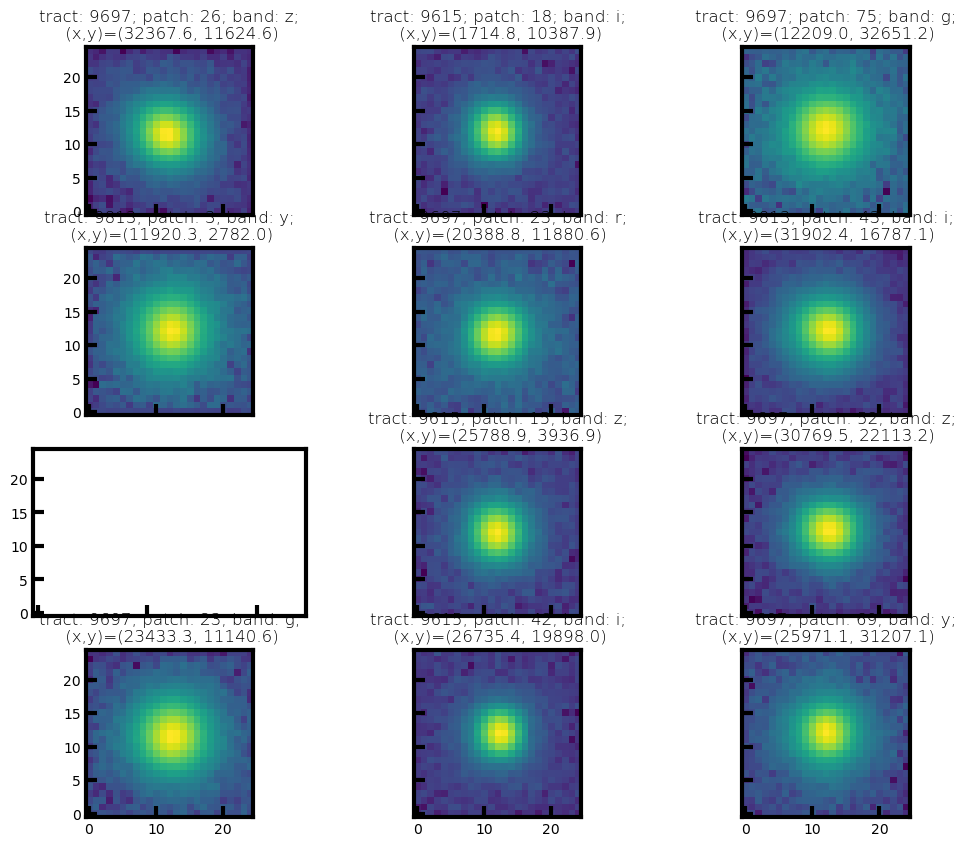

In [10]:
ncols = 3
nrows = numpatches/ncols # 3 plots per row
f, ax = plt.subplots(nrows=int(np.ceil(nrows)), ncols=int(ncols), sharey=True, sharex=True, figsize=(12,10))
axnum = 0
axs = ax.flatten()

for dataref in datarefs:
#    print(c.hasPsf())
    c = butler.get('deepCoadd_calexp', dataId = dataref)
    psf = c.getPsf()
    xsize = c.getDimensions().getX()
    ysize = c.getDimensions().getY()
    x0 = c.getX0()
    y0 = c.getY0()

    # Select a random point on the image and extract the PSF at that point:
    xpt = x0+random.random()*xsize
    ypt = y0+random.random()*ysize

    noimg_flag = False
    try:
        psfimage = psf.computeImage(geom.PointD(xpt, ypt))
    except:
        print('No images at the requested point.')
        noimg_flag = True
        
    if not noimg_flag:
        
        img = psfimage.array

        # Create an ImageNormalize object
        norm = ImageNormalize(img, interval=MinMaxInterval(),
                              stretch=LogStretch())

        axs[axnum].set_title('tract: '+str(datarefs[axnum]['tract'])+'; patch: '+str(datarefs[axnum]['patch'])+'; band: '+str(datarefs[axnum]['band'])+';\n (x,y)=('+str(round(xpt,1))+', '+str(round(ypt,1))+')')
        axs[axnum].imshow(img, norm=norm, origin='lower')

    axnum += 1

### Now confirm that the PSF is reasonably well-matched to stellar images by selecting a star in each image and subtracting the PSF at the star's position:

In [11]:
# Pick a bright star that was used to fit the PSF, and one that was used to calibrate the photometry:
src = butler.get('deepCoadd_forced_src', dataId=dataref)
ref = butler.get('deepCoadd_ref', dataId=dataref)

is_primary = (ref['detect_isPrimary'] == True) & (np.isfinite(src.getPsfInstFlux()))
deblended = (src["deblend_nChild"] == 0)
ptsource = (src['base_ClassificationExtendedness_flag'] == False)

# Make a copy of the star selection that is contiguous in memory:
stars = src[is_primary & deblended & ptsource].copy(deep=True)
stars_flux = stars.getPsfInstFlux()

# Pick stars between the 85th and 90th percentiles in PSF flux:
p85 = np.percentile(stars_flux, 85)
p90 = np.percentile(stars_flux, 90)
keepers = (stars_flux > p85) & (stars_flux < p90)


In [12]:
star_sel = random.choice(stars[keepers])
radec_star_sel = star_sel.getCoord()

In [13]:
wcs = c.getWcs()

cutoutSize = geom.ExtentI(100, 100) # size of cutout in pixels
xy = geom.Point2I(wcs.skyToPixel(radec_star_sel)) # central XY coordinate of our star's RA, Dec position

# Create the bounding box:
bbox = geom.Box2I(xy - cutoutSize//2, cutoutSize)

# Full patch image
#image = butler.get('calexp', immediate=True, dataId=dataid)
# Because an entire tract shares a WCS, the corner of the patch (or cutout) isn't necessarily at (X,Y)=(0,0). Get the XY0 pixel values:
xy0 = c.getXY0() 

# Postage stamp image only, using the bbox defined above:
parameters = {'bbox': bbox}
cutout_image = butler.get('deepCoadd_calexp', parameters=parameters, dataId=dataref).getMaskedImage()
# Because an entire tract shares a WCS, the corner of the patch (or cutout) isn't necessarily at (X,Y)=(0,0). Get the XY0 pixel values:
xy0_cutout = cutout_image.getXY0() 

#### Create a scaled image of the PSF, and subtract it from the cutout image:

In [14]:
psf = c.getPsf()
model = Exposure(cutout_image.getBBox(), dtype=np.float32)
model.setPsf(psf)
psfImage = psf.computeImage(star_sel.getCentroid())
flux = star_sel['base_PsfFlux_instFlux']-(star_sel['base_PsfFlux_area']*star_sel['base_LocalBackground_instFlux'])
psfBBox = psfImage.getBBox()
model.image[psfBBox, PARENT].scaledPlus(flux, psfImage.convertF())
residuals = cutout_image.clone()
residuals.image -= model.image

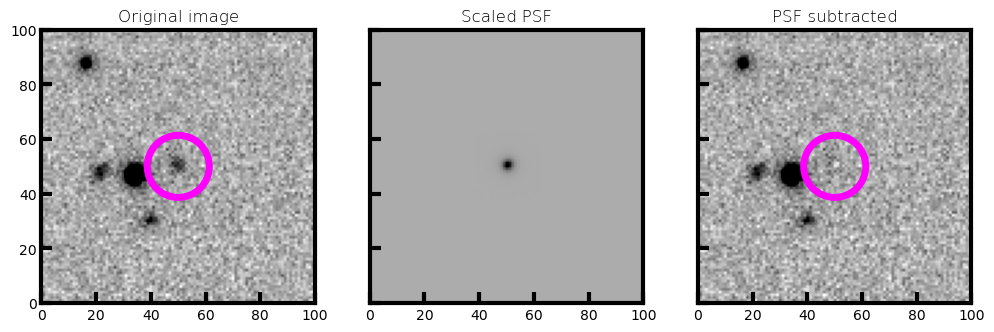

In [15]:
f, ax = plt.subplots(nrows=1, ncols=3, sharey=True, sharex=True, figsize=(12,6))
axs = ax.flatten()

vmin0, vmax0 = zscale.get_limits(cutout_image.image.array)
# Get the dimensions of the image so we can set plot limits
imsize = cutout_image.getDimensions()
axs[0].imshow(cutout_image.image.array, vmin=vmin0, vmax=vmax0, cmap='binary')
# Set the plot range to the dimensions:
axs[0].set_xlim(0,imsize[0])
axs[0].set_ylim(0,imsize[1])
axs[0].set_title('Original image')
axs[0].scatter(xy.getX()-xy0_cutout.getX(), xy.getY()-xy0_cutout.getY(), color='none', edgecolor='magenta', s=2000, linewidth=5)

# Get the dimensions of the image so we can set plot limits
imsize = model.image.getDimensions()
axs[1].imshow(model.image.array, vmin=vmin0, vmax=vmax0, cmap='binary')
# Set the plot range to the dimensions:
axs[1].set_xlim(0,imsize[0])
axs[1].set_ylim(0,imsize[1])
axs[1].set_title('Scaled PSF')

# Get the dimensions of the image so we can set plot limits
imsize = residuals.image.getDimensions()
axs[2].imshow(residuals.image.array, vmin=vmin0, vmax=vmax0, cmap='binary')
# Set the plot range to the dimensions:
axs[2].set_xlim(0,imsize[0])
axs[2].set_ylim(0,imsize[1])
axs[2].set_title('PSF subtracted')
axs[2].scatter(xy.getX()-xy0_cutout.getX(), xy.getY()-xy0_cutout.getY(), color='none', edgecolor='magenta', s=2000, linewidth=5)



### Now confirm that the PSF is reasonably well-matched to stellar images by selecting a bright star in each image and subtracting the PSF at the star's position:

### Check the images of some bright stars, and see how well the PSF matches the stellar image:
For the images selected at random, pick (again, at random) a bright star and look at (a) its image, (b) an image of the scaled PSF at its position, and (c) the residuals after subtracting the scaled PSF from the original image.

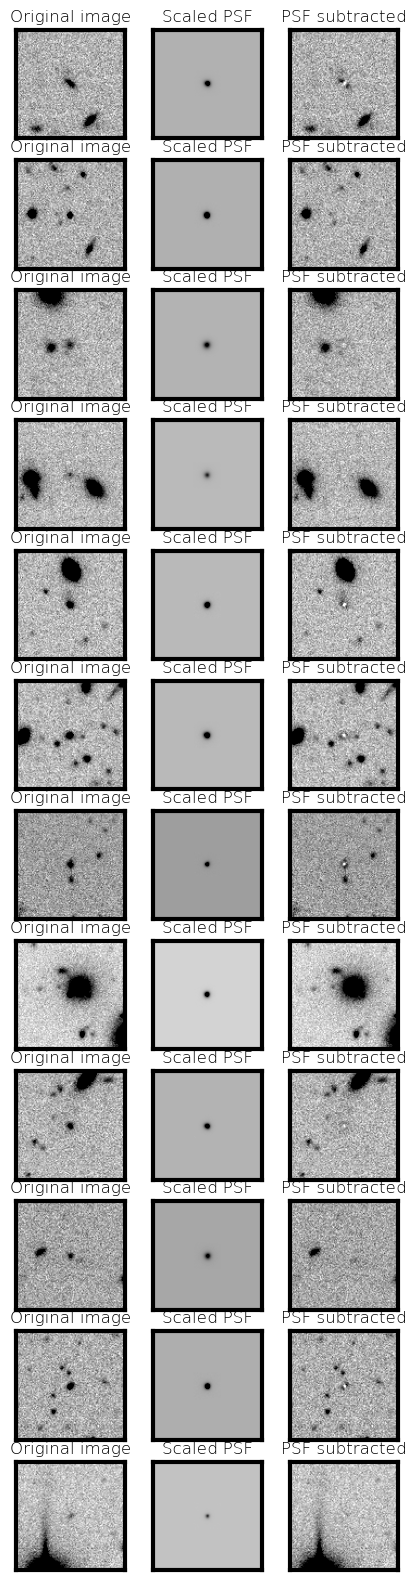

In [16]:
ncols = 3
nrows = numpatches # a star from each patch per row
f, ax = plt.subplots(nrows=int(nrows), ncols=int(ncols), sharey=True, sharex=True, figsize=(5, 20))
axnum = 0
axs = ax.flatten()
plt.rcParams.update({'font.size' : 10})

for dataref in datarefs:
    c = butler.get('deepCoadd_calexp', dataId = dataref)

    # Load the source catalog:
    src = butler.get('deepCoadd_forced_src', dataId=dataref)
    ref = butler.get('deepCoadd_ref', dataId=dataref)

    is_primary = (ref['detect_isPrimary'] == True) & (np.isfinite(src.getPsfInstFlux()))
    deblended = (src["deblend_nChild"] == 0)
    ptsource = (src['base_ClassificationExtendedness_flag'] == False)

    # Make a copy of the star selection that is contiguous in memory:
    stars = src[is_primary & deblended & ptsource].copy(deep=True)
    stars_flux = stars.getPsfInstFlux()

    # Pick stars between the 85th and 90th percentiles in PSF flux:
    p85 = np.percentile(stars_flux, 85)
    p90 = np.percentile(stars_flux, 90)
    keepers = (stars_flux > p85) & (stars_flux < p90)

    wcs = c.getWcs()
    # Because an entire tract shares a WCS, the corner of the patch (or cutout) isn't necessarily at (X,Y)=(0,0). Get the XY0 pixel values:
    xy0 = c.getXY0() 

    # size of image cutout in pixels
    imsize = 100
    cutoutSize = geom.ExtentI(imsize, imsize)

    # Pick one from the table at random, but require it to have coordinates
    #   such that the bounding box will not extend beyond the patch's border:
    oksrc = False
    while not oksrc:
        coadd_dimen = c.getDimensions()
        # Select a bright star:
        star_sel = random.choice(stars[keepers])
        radec_star_sel = star_sel.getCoord()
        xy = star_sel.getCentroid()
        if (xy.getX()-xy0.getX() > imsize/2.0) and (xy0.getX()+coadd_dimen[0]-xy.getX() > imsize/2.0) and\
           (xy.getY()-xy0.getY() > imsize/2.0) and (xy0.getY()+coadd_dimen[1]-xy.getY() > imsize/2.0):
            oksrc = True

    # Create the bounding box:
    xy = geom.Point2I(xy)
    bbox = geom.Box2I(xy - cutoutSize//2, cutoutSize)

    # Postage stamp image only, using the bbox defined above:
    parameters = {'bbox': bbox}
    cutout_image = butler.get('deepCoadd_calexp', parameters=parameters, dataId=dataref)
    # Because an entire tract shares a WCS, the corner of the patch (or cutout) isn't necessarily at (X,Y)=(0,0). Get the XY0 pixel values:
    xy0_cutout = cutout_image.getXY0() 

    psf = c.getPsf()
    model = Exposure(cutout_image.getBBox(), dtype=np.float32)
    model.setPsf(psf)
    psfImage = psf.computeImage(star_sel.getCentroid())
    flux = star_sel['base_PsfFlux_instFlux']-(star_sel['base_PsfFlux_area']*star_sel['base_LocalBackground_instFlux'])
    psfBBox = psfImage.getBBox()
    model.image[psfBBox, PARENT].scaledPlus(flux, psfImage.convertF())
    residuals = cutout_image.clone()
    residuals.image -= model.image

    vmin0, vmax0 = zscale.get_limits(cutout_image.image.array)
    # Get the dimensions of the image so we can set plot limits
    imsize = cutout_image.getDimensions()
    axs[axnum].imshow(cutout_image.image.array, vmin=vmin0, vmax=vmax0, cmap='binary')
    # Set the plot range to the dimensions:
    axs[axnum].set_xlim(0,imsize[0])
    axs[axnum].set_ylim(0,imsize[1])
    axs[axnum].set_title('Original image')
    axs[axnum].get_xaxis().set_visible(False)
    axs[axnum].get_yaxis().set_visible(False)

    axnum += 1

    # Get the dimensions of the image so we can set plot limits
    imsize = model.image.getDimensions()
    axs[axnum].imshow(model.image.array, vmin=vmin0, vmax=vmax0, cmap='binary')
    # Set the plot range to the dimensions:
    axs[axnum].set_xlim(0,imsize[0])
    axs[axnum].set_ylim(0,imsize[1])
    axs[axnum].set_title('Scaled PSF')
    axs[axnum].get_xaxis().set_visible(False)
    axs[axnum].get_yaxis().set_visible(False)
    
    axnum += 1

    # Get the dimensions of the image so we can set plot limits
    imsize = residuals.image.getDimensions()
    axs[axnum].imshow(residuals.image.array, vmin=vmin0, vmax=vmax0, cmap='binary')
    # Set the plot range to the dimensions:
    axs[axnum].set_xlim(0,imsize[0])
    axs[axnum].set_ylim(0,imsize[1])
    axs[axnum].set_title('PSF subtracted')
    axs[axnum].get_xaxis().set_visible(False)
    axs[axnum].get_yaxis().set_visible(False)

    axnum += 1



Most of these subtracted well. The ones that did not are obviously mistakenly classified as "stars" by the star/galaxy classifier, and thus should not be expected to subtract off well.

### Use the "hasPsf" method to check whether a larger number of the patch images have an associated PSF model:
(Note: we use only a randomly-selected subset of images because it takes too long to extract the coadd for all images in the repository.)

In [17]:
# Select some tract/patch combinations from the repo at random:
numpatches_boolcheck = 100
img_sel_boolcheck = random.choices(datarefs, k=numpatches_boolcheck)

In [20]:
datarefs_boolcheck = []
psfflags = []

for did in img_sel_boolcheck:
    # Sometimes images fail, so test whether the dataset exists before grabbing it:
    if butler.datasetExists('deepCoadd_calexp', dataId = did):
        calexp = butler.get('deepCoadd_calexp', dataId = did)
        psfflags.append(calexp.hasPsf())
        datarefs_boolcheck.append(dataref)


/tmp/ipykernel_26156/3249827235.py:6: FutureWarning: Call to deprecated method datasetExists. (Butler.datasetExists() has been replaced by Butler.exists(). Will be removed after v26.0.) -- Deprecated since version v26.0.
  if butler.datasetExists('deepCoadd_calexp', dataId = did):


### Confirm that _all_ images that we checked have an associated PSF model:

In [21]:
assert(np.all(psfflags)), 'FALSE: not all patches have an associated PSF model.'
print('All patches have an associated PSF model: ',np.all(psfflags))

All patches have an associated PSF model:  True
